# Neural Operators

Quinn Heng-Martin, Brandt Benfield; Colorado State University 2025

## Introduction

Neural Networks (NNs) are often described as universal function approximators, mapping an arbitrary set of inputs to outputs. This is certainly a very useful task, however in physics and engineering we are often interested in examining systems that produce different functions characterized by the same underlying behavior, depending on some initial or boundary conditions. It is the underlying behaviour we are interested in, not the particular function. That is, we seek to find mappings from functions to functions. This actually expands our problem space more than one might think: since there are an infinite number of functions that are completely unrelated (the family $\delta(x-x_0)$ for example), our parameter space is actually *infinite dimensional*. This might seem an insurmountable challenge, but NNs provide a nice starting point. This function-to-function mapping is precisely what an operator is, so a NN-derived architecture to solve these problems, naturally, is called a Neural Operator (NO). NOs were originally proposed by researchers at Caltech in 2020 [[1](https://arxiv.org/abs/2010.08895)] [[2](https://arxiv.org/abs/2108.08481)] - We seek to use the NO library published by the this team ([arxiv](https://arxiv.org/abs/2412.10354)) to create short- to medium-term weather forecasts for Colorado (a conveniently rectangular state).

### On the Technical Details
The key idea is that, in order to work on functions, rather than vectors, we must use a functional version of the dot product. This turns out to be integration, which raises the new problem of how to efficiently compute this integral. Fourier Analysis comes to the aid here - not only by standing out as the language for solving tools in the first place, but also thanks to the convolution theorem: If we want to take this convolution integral over all space, we can simply take the dot product of it's fourier transform!

The internal structure of a single Fourier layer is as so: It receives an input function v(x) as a finite number of input-output pairs. The core of the Fourier layer lies in its application of the Fourier transform (F) to the input, moving the function from the physical space to the Fourier space and back between each layer. In this spectral domain the different frequency modes of the function are represented. A linear operation with a filter kernel is then performed. This operation allows the network to selectively modify or emphasize certain frequency components. Subsequently, an inverse Fourier transform (inv(f)) brings the processed function back to the physical space. In parallel to this spectral pathway, the input function v(x) also undergoes a point-wise linear transformation, to account for any non-periodic features. The outputs of the spectral pathway (after the inverse Fourier transform) and the point-wise transformation are then added together. Finally, a non-linear activation function σ is applied to the summed result preparing the output for the next layer in the sequence. By stacking multiple such Fourier layers the FNO can learn complex mappings between function spaces, making it particularly effective for solving partial differential equations and other tasks involving continuous functions. While NOs are capable of evaluation at continuous points, they are often trained on a discrete grid such that the training implemented using Fast Fourier Transforms, leading to computational efficiency and the ability to handle high-dimensional input and output spaces.[[2](https://arxiv.org/pdf/2108.08481)]


### The Gameplan (Methodology):

The model will be shown climate data for the state of CO in the year 2022 pertaining to temperature, pressure, humidity, and atmospheric flow, with the goal of predicting some or all of those variables at a later point in time. All training data is taken from the [
ERA5 hourly data on single levels from 1940 to present](https://doi.org/10.24381/cds.adbb2d47) and converted to CSV format for communicative/hand-in purposes.

In [2]:
# Neural Operator install Options:
#!pip install neuraloperator
#!pip install git+https://github.com/neuraloperator/neuraloperator.git
#!conda install conda-forge::neuraloperator

from neuralop.training import Trainer
from neuralop.models import FNO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

# Dataset Preparation
class WeatherTensorDataset(Dataset):          # This class is a custom dataset loader that will load preprocessed
    def __init__(self, data_path):            # weather data (saved as a .pt file) into PyTorch’s data pipeline.
        self.samples = torch.load(data_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return {'x': self.samples[idx][0], 'y': self.samples[idx][1]}

First, let's load up our data and get a look at it:

,valid_time,latitude,longitude,u10,v10,surface_dewpoint,surface_temperature,surface_pressure,u10n,v10n
0,2022-01-01 03:00:00,41.0,-109.0,0.694458,-0.103119,-12.12968,-10.70420,77215.0,0.223984,0.018707
1,2022-01-01 03:00:00,41.0,-108.5,0.498169,0.364655,-12.65702,-11.20420,77910.0,0.170273,0.116364
2,2022-01-01 03:00:00,41.0,-108.0,-0.283081,0.928131,-12.59843,-10.97373,77852.0,-0.130508,0.344879
3,2022-01-01 03:00:00,41.0,-107.5,-1.179565,1.212311,-13.98710,-11.95030,75851.0,-0.657852,0.766754
4,2022-01-01 03:00:00,41.0,-107.0,-0.895386,0.902740,-14.65116,-12.76670,73532.0,-0.682266,0.731598


,valid_time,latitude,longitude,u10,v10,surface_dewpoint,surface_temperature,surface_pressure,u10n,v10n
56361,2022-04-15 09:00:00,39.0,-106.0,2.519684,0.632660,-14.18270,-8.56675,68882.750,0.698151,0.175812
36963,2022-03-10 09:00:00,37.5,-107.5,1.502731,0.148987,-14.05637,-12.28092,70512.310,1.159515,0.242523
19138,2022-02-05 09:00:00,38.0,-102.5,2.792755,3.161896,-12.77964,-3.57883,88782.375,2.390900,2.711838
112754,2022-07-28 21:00:00,40.5,-102.0,-2.554626,0.742813,13.76724,26.02920,89636.940,-2.975479,0.861099
99005,2022-07-03 09:00:00,39.5,-106.5,-0.323273,1.567673,5.21987,7.29727,71280.750,-0.202454,0.836380


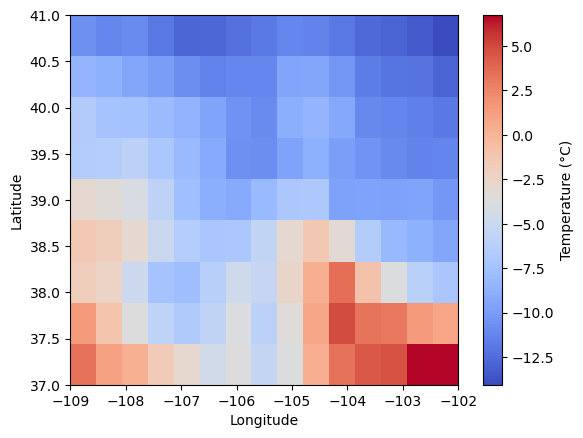

In [3]:
df = pd.read_csv('data2022/accum_data.csv')
df.valid_time = df.valid_time.astype('datetime64[s]')
df[['surface_dewpoint', 'surface_temperature']] -= 273.15

W = len(df.longitude.unique())
H = len(df.latitude.unique())
T = len(df.valid_time.unique())
extent = (df.longitude.min(), df.longitude.max(), df.latitude.min(), df.latitude.max())

display(df.head())
display(df.sample(5))
initial_temp = (df[df.valid_time=='2022-01-01 3:00:00']
                .pivot(index='latitude',columns='longitude',
                       values='surface_temperature')
                .sort_index(ascending=False)
               )
def plot(data, label='Temperature (°C)', title=None):
  plt.imshow(data, aspect=W/H, extent=extent, cmap='coolwarm')  # or 'viridis' if you prefer
  plt.colorbar(label=label)
  if title:
      plt.title(title)
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()

plot(initial_temp)

Nice! next up, a neural operator should benefit from knowing the coordinates of it's data, including time. Let's make a float-valued time that a NO can understand:

In [4]:
# Assign each time a timestep float
times = df['valid_time'].sort_values().unique()
dt = times[1]-times[0] # The model will see a day that is 24H/dt ticks long
df['time'] = (df['valid_time']-times[0])/dt
(times-times[0])/dt

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.457e+03, 1.458e+03,
       1.459e+03])

Now package everything into 3d data:

In [ ]:
# Drop valid_time and move all coordinate channels to the end as the model expects: (there's definitely a more elegant way to do this..)
channels = list(df.columns.drop(['valid_time', 'latitude', 'longitude']))+['latitude','longitude']
C = len(channels)
data_array = (df[channels]
              .sort_values(['time', 'latitude', 'longitude'])
              .values
              .reshape([T,H,W,C])
             )
print(f'{data_array.shape = } = (T, H, W, C)')

data_array.shape = (1460, 9, 15, 10) = (T, H, W, C)


As a sanity check, let's show that inital temperature distribution again:

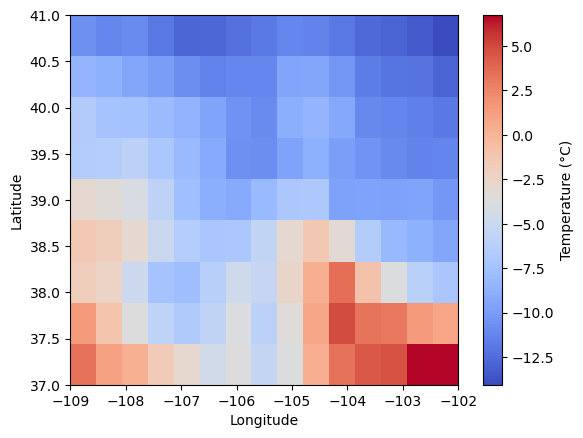

In [6]:
plot(data_array[0,::-1,:,3])

Looking good!

In [7]:
data = (torch.tensor(data_array, dtype=torch.float32)
        .transpose(0,3))  # Place channels up front to appease neuralop

## Experiment 1:
As a diagnostic before getting into heavier computation, let's see if the NO can predict the temperature distribution one timestep later:

In [8]:
# Make some input/output pairs:

input_tensor = data[:,:,:,:-1]
input_tensors = input_tensor.split(split_size=1,dim=3)
output_tensor = data[[3],:,:,1:]  # Just try to predict the next temperature

In [10]:
# Split data into pairs of timesteps. Given one timestep, the model should predict the next one
from itertools import pairwise
#chunks = map(torch.squeeze, data.split(1,dim=3))
#chunks = tuple(pairwise(chunks))
chunks = list(zip(map((lambda x: x.squeeze(3)), input_tensor.split(1,dim=3)),
                  map((lambda x: x.squeeze(3)), output_tensor.split(1,dim=3))))
print(f'{chunks[0][1].shape = }')
torch.save(chunks, 'weather_chunks.pt')
tuple(pairwise(torch.tensor((1,2,3,4,5,6)).split(1, dim=0)))  # Illustration of split and pairwise working together

chunks[0][1].shape = torch.Size([1, 9, 15])


((tensor([1]), tensor([2])),
 (tensor([2]), tensor([3])),
 (tensor([3]), tensor([4])),
 (tensor([4]), tensor([5])),
 (tensor([5]), tensor([6])))

In [13]:
# Dataset Splitting
full_dataset = WeatherTensorDataset('weather_chunks.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model Setup
in_channels = C # # of input
out_channels = 1 # # of output

# Initialize the model
model = FNO(n_modes=(12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, device=device, eval_interval=1, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

In [14]:
train_dataset[0]['x'].shape, train_dataset[0]['y'].shape

(torch.Size([10, 9, 15]), torch.Size([1, 9, 15]))

In [15]:
# Train the model
trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 1167 samples
Testing on [292] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([4, 1, 9, 15])
[0] time=15.60, avg_loss=4.1192, train_err=16.4626
Eval: test_l2=1.1818
[1] time=13.80, avg_loss=1.7222, train_err=6.8830
Eval: test_l2=1.3606
[2] time=14.31, avg_loss=1.3166, train_err=5.2621
Eval: test_l2=1.1436
[3] time=14.50, avg_loss=1.1330, train_err=4.5279
Eval: test_l2=1.1751
[4] time=14.11, avg_loss=1.0021, train_err=4.0048
Eval: test_l2=1.0134
[5] time=14.76, avg_loss=0.8947, train_err=3.5757
Eval: test_l2=0.8468
[6] time=16.28, avg_loss=0.8985, train_err=3.5909
Eval: test_l2=0.8678
[7] time=14.39, avg_loss=0.8546, train_err=3.4155
Eval: test_l2=0.8478
[8] time=15.07, avg_loss=0.8681, train_err=3.4696
Eval: test_l2=0.8508
[9] time=15.65, avg_loss=0.8446, train_err=3.3755
Eval: test_l2=0.8510


{'train_err': 3.375465980539583,
 'avg_loss': 0.8445896026714296,
 'avg_lasso_loss': None,
 'epoch_train_time': 15.6523297549993,
 'test_l2': tensor(0.8510)}

Strangely, I only get this NNPACK! warning occasionally. It seems to lead to about a 3x slowdown. Painful, considering how long training is taking already...

Looking at the losses, it looks like we really only needed a couple of epochs to train! (the error usually off pretty early, and the loss falls off early if ever) So how's it look?

[W508 23:29:40.151322629 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


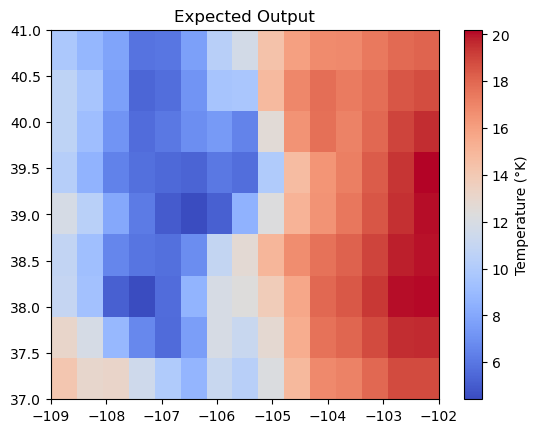

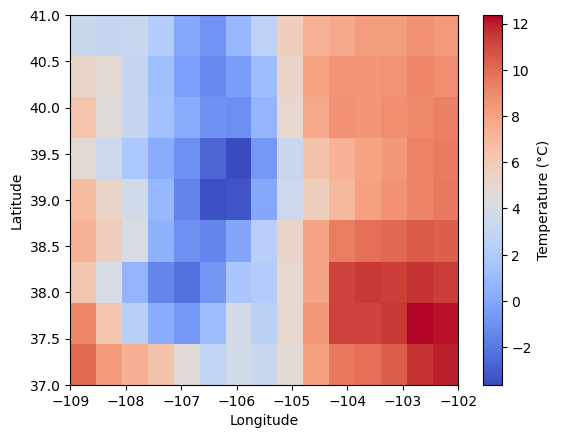

In [16]:
x_example = test_dataset[73]['x'].unsqueeze(0)
y_expected = test_dataset[73]['y']
y_predicted = model(x_example).squeeze()

plt.imshow(y_expected.squeeze().numpy()[::-1,:], cmap='coolwarm', aspect=W/H, extent=extent)
plt.colorbar(label='Temperature (°K)')
plt.title('Expected Output')
plt.show()

plot(y_predicted.squeeze().detach().numpy()[::-1,:])
plt.show()

In [17]:
%timeit y_predicted = model(x_example)

10.4 ms ± 653 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not terrible... let's crank it up!

## Experiment two:

Can the default FNO predict all of the channels we're feeding into it?

In [18]:
# Dataset Splitting

ticks_per_group = 4

input_tensor = data[:,:,:,:-ticks_per_group]
output_tensor = data[:-3,:,:,ticks_per_group:]  # Try to predict all variables at the next timestep

time_dim = 3
chunks = list(zip(map((lambda x: x.squeeze(3)), input_tensor.split(ticks_per_group, dim=time_dim)),
                  map((lambda x: x.squeeze(3)), output_tensor.split(ticks_per_group, dim=time_dim))))
torch.save(chunks, 'weather_chunks2.pt')
full_dataset = WeatherTensorDataset('weather_chunks2.pt')

train_size = int(0.8 * len(full_dataset)) #80% for train
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

train_dataset[0]['y'].shape # C x T x H x W, where T is the number of observation times

torch.Size([7, 9, 15, 4])

In [19]:
# Model Setup

in_channels = train_dataset[0]['x'].shape[0] # # of input
out_channels = train_dataset[0]['y'].shape[0] # # of output

# Initialize the model
model = FNO(n_modes=(12, 12, 12), hidden_channels=32, in_channels=in_channels, out_channels=out_channels)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer with learning rate 0.001
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # Learning rate scheduler

# Training Setup
trainer = Trainer(model=model, n_epochs=10, eval_interval=1, device=device, verbose=True)

# Wrap the test_loader in a dictionary
test_loaders = {'test': test_loader}

trainer.train(train_loader, test_loaders, optimizer, scheduler)

Training on 291 samples
Testing on [73] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([5, 7, 9, 15, 4])
[0] time=16.51, avg_loss=1121.6046, train_err=5531.9818
Eval: test_l2=388.1438
[1] time=14.81, avg_loss=298.3505, train_err=1471.5254
Eval: test_l2=518.7864
[2] time=15.53, avg_loss=289.1291, train_err=1426.0433
Eval: test_l2=474.7342
[3] time=15.04, avg_loss=253.5901, train_err=1250.7579
Eval: test_l2=263.4017
[4] time=14.93, avg_loss=171.1536, train_err=844.1642
Eval: test_l2=122.9679
[5] time=14.94, avg_loss=148.8275, train_err=734.0476
Eval: test_l2=162.4163
[6] time=15.22, avg_loss=126.1177, train_err=622.0381
Eval: test_l2=176.1114
[7] time=14.62, avg_loss=143.6740, train_err=708.6292
Eval: test_l2=174.9796
[8] time=14.92, avg_loss=103.1880, train_err=508.9442
Eval: test_l2=161.7969
[9] time=14.78, avg_loss=100.2312, train_err=494.3609
Eval: test_l2=142.8719


{'train_err': 494.360893637447,
 'avg_loss': 100.23124647632088,
 'avg_lasso_loss': None,
 'epoch_train_time': 14.781201416999465,
 'test_l2': tensor(142.8719)}

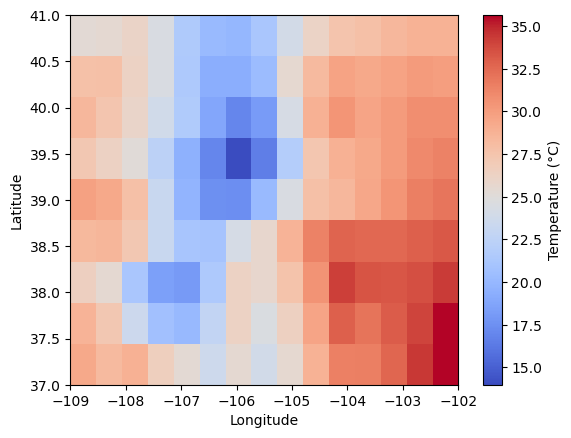

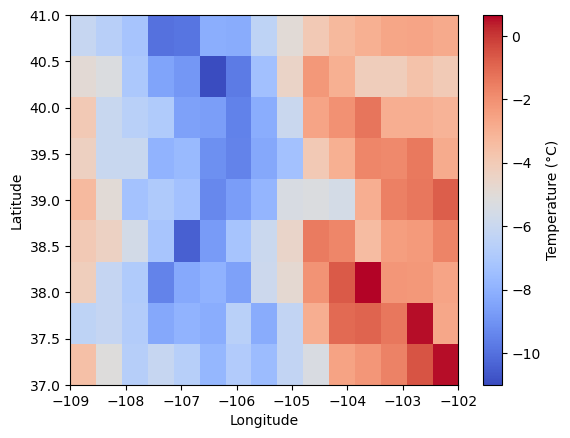

In [20]:
look_at=42
x_example = test_dataset[look_at]['x'].unsqueeze(0)
y_expected = test_dataset[look_at]['y'][:,:,:,ticks_per_group-1]
plot(y_expected.numpy()[3,::-1,:])
y_predicted = model(x_example).squeeze().detach().numpy()[:,:,:,ticks_per_group-1]
plot(y_predicted[3,::-1,:])

Well that's worse...but not much worse (usually)! Let's look at the rest of the channels:

i = 0


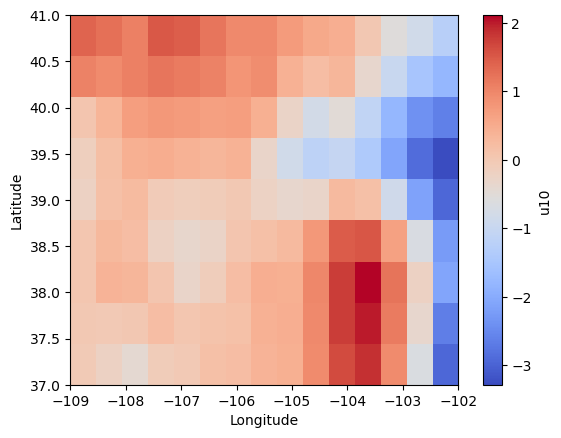

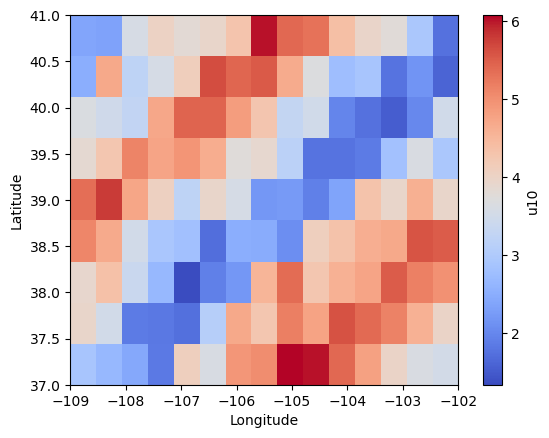

i = 1


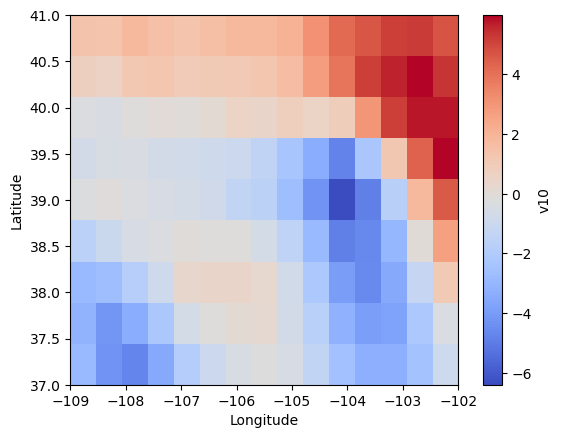

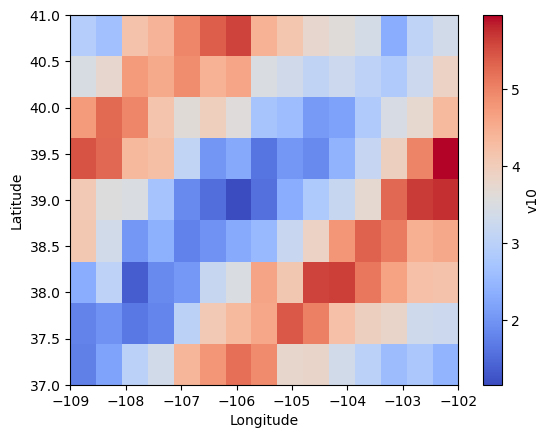

i = 2


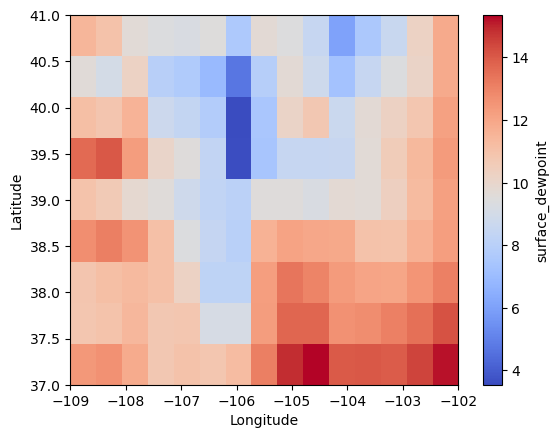

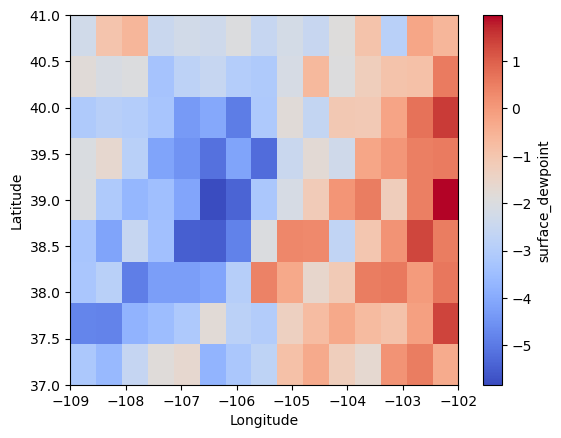

i = 3


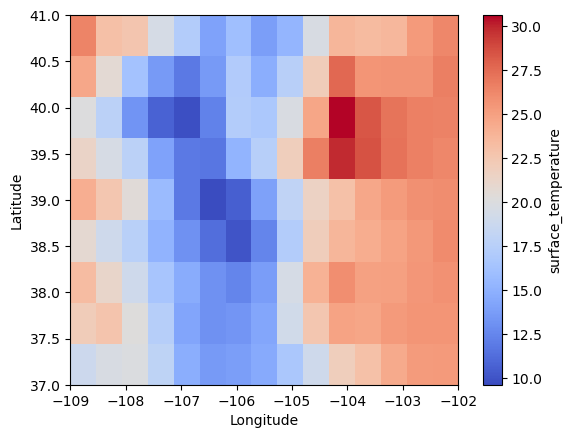

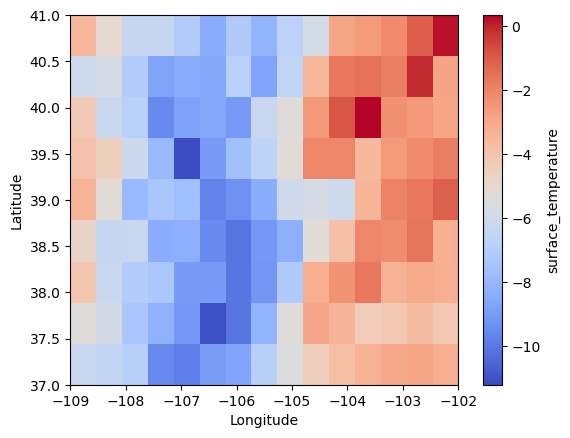

i = 4


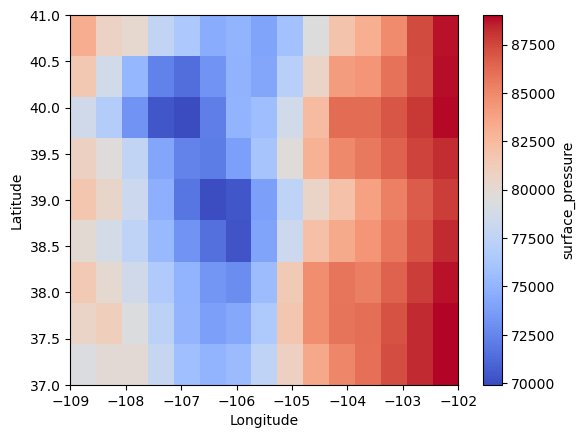

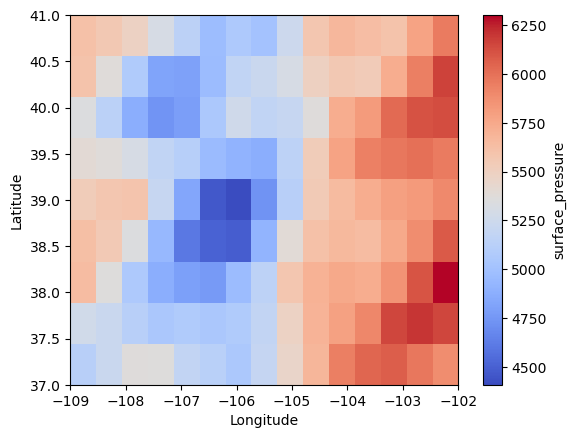

i = 5


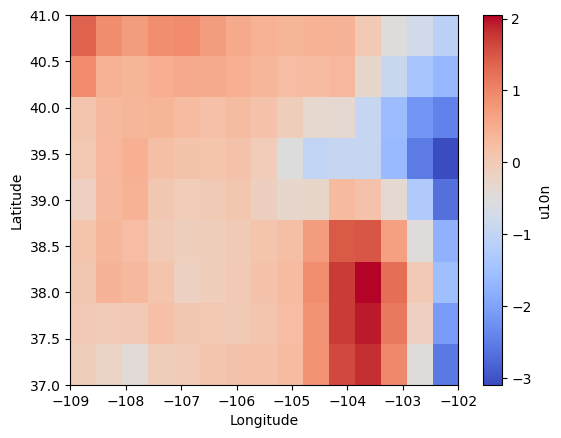

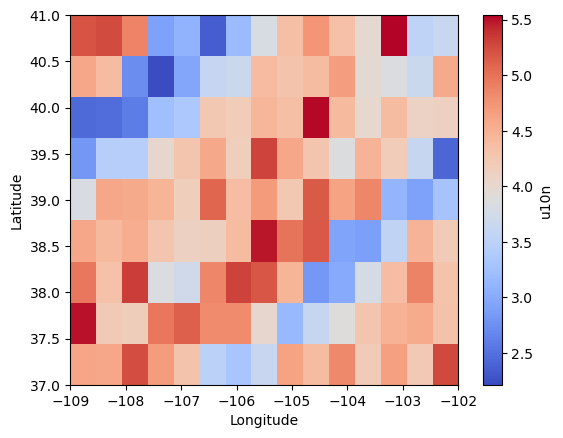

i = 6


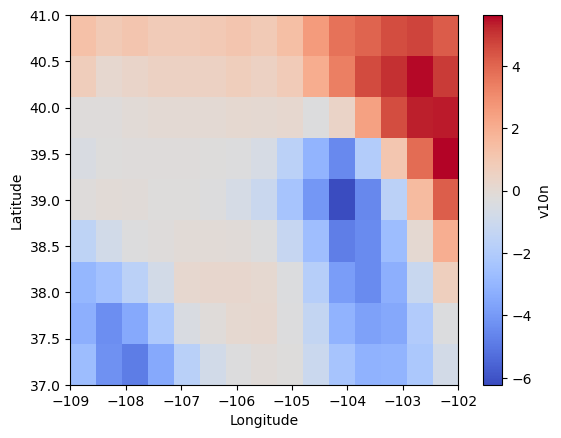

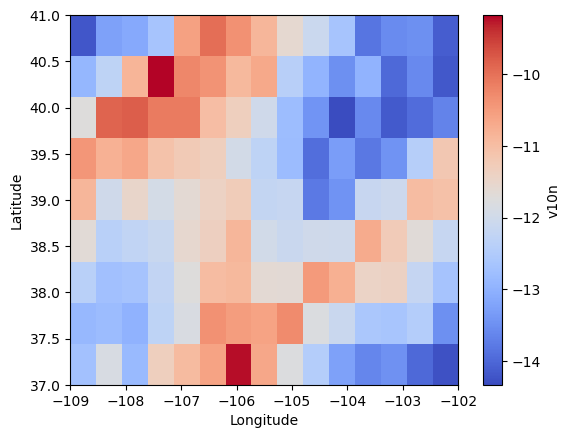

In [21]:
out = model(test_dataset[look_at]['x'].unsqueeze(0)).squeeze()
for i in range(out.shape[0]):
    print(f'{i = }')
    expected = test_dataset[look_at]['y'][i,:,:,0]#ticks_per_group-1]
    prediction = out[i,:,:,0]#ticks_per_group-1]
    plot(expected, label=channels[i])
    plot(prediction.detach().numpy(), label=channels[i])

In [22]:
%timeit y_predicted = model(x_example)

17.9 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Well... it's got the spirit at least.. Furthermore, the model is calculating more than a single time step at once! It still isn't getting all of the variables predicted though...

# Conclusion

There are a few obvious things that could improve the model, the first of which being better data. As is, the border into the unknown takes up a significant part of the data: getting a larger geographic area would be greatly beneficial, as would increasing the resolution of the training data. Secondly, directly using an l2 norm for evaluating the loss breaks my physicist heart. A better treatment would involve tying knowledge of the Navier-Stokes equations or Clausius-Clapeyron relation to more directly approach the underlying physics.

While Neural operators seem a promising tool for solving PDE's, the tradeoff they make with an increased training time cannot be ignored. They are effectively acting as continuous CNNs paired alongside a group of regular NNs, so this is to be expected. 

## Appendix: Data Conversion

In [23]:
#please don't remove I need them every time I pull from main
#!apt-get install -y libeccodes0 libeccodes-dev
#!pip install cfgrib xarray

In [24]:
import xarray as xr

# Load GRIB (or grb) file (from what I found they act the same)
ds = xr.open_dataset('CaribbeanWeatherTest.wind.7days.grb', engine='cfgrib')

# Inspect the dataset
print(ds)
ds.variables.keys()

ValueError: unrecognized engine 'cfgrib' must be one of your download engines: ['netcdf4', 'scipy', 'store', 'zarr']. To install additional dependencies, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [ ]:
# For example, if 'time' is a variable:
time = ds['time']
print(time)